# Medium Builder Introduction

This Jupyter notebook provides an introduction to the basic usage of medium builder.
Medium builder is a utility to create acoustic media for Fullwave simulations.

You can create the acoustic medium by combining simple geometric shapes such as rectangles and circles.

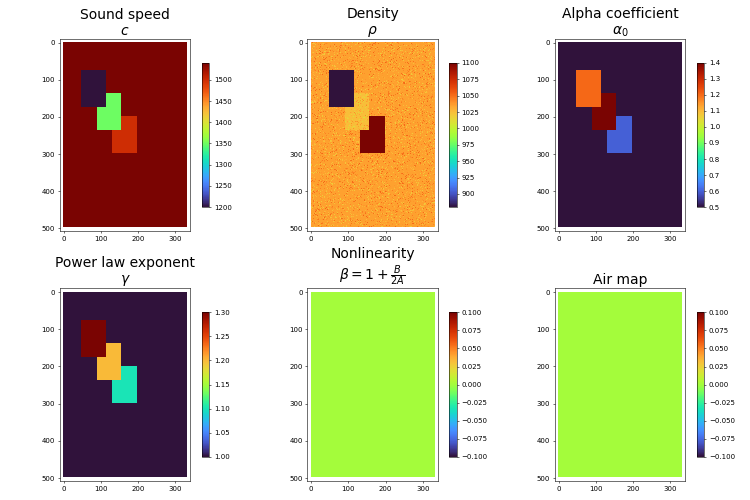


## Prerequisites

Before running this notebook, ensure that you have Fullwave 2.5 and its dependencies installed.

You can follow the installation instructions provided in the [Fullwave 2.5 GitHub repository](https://github.com/pinton-lab/fullwave25#install)


## Basic steps

The basic steps are as follows:

1. Preparation
   1. Import necessary libraries and modules.
   2. Define the working directory.
2. Simulation configuration
   1. Define the computational grid parameters. (`fullwave.Grid`)
   2. Define the acoustic medium properties with `fullwave.Medium` and `MediumBuilder`
   3. Define the acoustic source position and the time-varying source signal. (`fullwave.Source`)
   4. Define the sensor positions to record the wavefield. (`fullwave.Sensor`)
3. Simulation setup
   1. Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)
   2. Execute the simulation.
4. Post-process
   1. Load the recorded wavefield data.
   2. visualize the results.


## Step 1: Preparation

### Step 1.1: Import necessary libraries and modules

In this step, we import the required libraries and modules for the simulation. We use `pathlib` for handling file paths, `numpy` for numerical operations, and `fullwave` along with its utility functions for wave propagation simulations and data visualization.


In [1]:
# pathlib for handling file paths
from pathlib import Path

# numpy for numerical operations
import numpy as np

# fullwave library and its utility functions
import fullwave
from fullwave import MediumBuilder, presets
from fullwave.utils import plot_utils, signal_process
from fullwave.utils.coordinates import map_to_coords

### Step 1.2: Define the working directory

In this step, we set up the working directory where simulation outputs will be saved.
Using the `Path` module from the `pathlib` library, we define the path to the working directory.


In [2]:
# we will make a working directory called "simple_plane_wave" inside "outputs" directory.
work_dir = Path("./outputs/") / "medium_builder"

# create the working directory if it does not exist
work_dir.mkdir(parents=True, exist_ok=True)

## Step 2

### Step 2.1: Define the computational grid parameters. (`fullwave.Grid`)

In this step, we define the computational grid parameters using the `fullwave.Grid` class. This includes specifying the domain size (`domain_size`) in meters, center frequency (`f0`) of the source in Hz, base sound speed (`c0`) in m/s, and duration (`duration`) of the simulation in seconds.

As an optional step, we can also define spatial resolution (`ppw`) and temporal resolution (`cfl`). If not specified, these will be set to default values.


In [3]:
domain_size = (42.5e-3 * 1.5, 42.5e-3)  # meters
f0 = 1e6  # Hz
c0 = 1540  # m/s
duration = domain_size[0] / c0 * 2  # seconds

# setup the Grid instance
grid = fullwave.Grid(
    domain_size=domain_size,
    f0=f0,
    duration=duration,
    c0=c0,
)

You can print the summary more easily by using the `print_grid_info` function.


In [4]:
grid.print_info()

Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.38e-02 m, 4.25e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 8.28e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (497, 331)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4968
  is 3D simulation (grid.is_3d): False


### Step 2.2: Define the acoustic medium properties. `fullwave.Medium` and `MediumBuilder`

We will use `MediumBuilder` to create the acoustic medium for the simulation.
`MediumBuilder` allows us to create complex acoustic media by combining simple geometric shapes such as rectangles and circles.
First, we initialize the `MediumBuilder` with the defined grid.


First, we define the base medium properties as 2D NumPy arrays.


In [5]:
sound_speed = 1500
density = 1100
alpha_coeff = 0.6
alpha_power = 1.1
beta = 0.0

# define background
# background domain is defined as default properties.

# default
# sound speed: 1540 m/s
# density: 1000 kg/m^3
# alpha_coeff: 0.5 dB/(MHz^y cm)
# alpha_power: 1.0
# beta: 0.0
background = presets.BackgroundDomain(
    grid=grid,
    background_property_name=None,
)

Next, we define the small object to be embedded in the medium using the `presets.SimpleDomain`.

It defines a rectangular domain with geometry mask and material properties.


In [6]:
geometry = np.zeros((grid.nx, grid.ny), dtype=int)
geometry[
    round(grid.nx // 2 - grid.nx * 0.1) : round(grid.nx // 2 + grid.nx * 0.1),
    round(grid.ny // 2 - grid.ny * 0.1) : round(grid.ny // 2 + grid.ny * 0.1),
] = 1
maps = {
    "sound_speed": sound_speed * geometry,
    "density": density * geometry,
    "alpha_coeff": alpha_coeff * geometry,
    "alpha_power": alpha_power * geometry,
    "beta": beta * geometry,
}
simple_domain_1 = presets.SimpleDomain(
    grid=grid,
    name="simple1",
    geometry=geometry,
    maps=maps,
)

Similarly, we can add more domains as needed.


In [7]:
geometry_2 = np.zeros((grid.nx, grid.ny), dtype=int)
geometry_2[
    round(grid.nx // 8 * 3 - grid.nx * 0.1) : round(grid.nx // 8 * 3 + grid.nx * 0.1),
    round(grid.ny // 8 * 3 - grid.ny * 0.1) : round(grid.ny // 8 * 3 + grid.ny * 0.1),
] = 1
maps_2 = {
    "sound_speed": sound_speed * geometry_2 * 0.9,
    "density": density * geometry_2 * 0.9,
    "alpha_coeff": 1.4 * geometry_2,
    "alpha_power": 1.2 * geometry_2,
    "beta": beta * geometry_2 * 0.2,
}
simple_domain_2 = presets.SimpleDomain(
    grid=grid,
    name="simple2",
    geometry=geometry_2,
    maps=maps_2,
)

geometry_3 = np.zeros((grid.nx, grid.ny), dtype=int)
geometry_3[
    round(grid.nx // 4 - grid.nx * 0.1) : round(grid.nx // 4 + grid.nx * 0.1),
    round(grid.ny // 4 - grid.ny * 0.1) : round(grid.ny // 4 + grid.ny * 0.1),
] = 1
maps_3 = {
    "sound_speed": sound_speed * geometry_3 * 0.8,
    "density": density * geometry_3 * 0.8,
    "alpha_coeff": 1.2 * geometry_3,
    "alpha_power": 1.3 * geometry_3,
    "beta": beta * geometry_3 * 0.3,
}
simple_domain_3 = presets.SimpleDomain(
    grid=grid,
    name="simple3",
    geometry=geometry_3,
    maps=maps_3,
)

Additionally, we can add scatterers using the presets.Scatterers class.
Scatterers are small, randomly distributed objects that simulate tissue heterogeneities.
This is essential for simulating the propagation of waves in biological tissues realistically.

Scatterers are added to the density as perturbations.

In this example, simple_domain_1 is modeled as an anechoic object. Therefore, we don't add scatterers inside the object.


In [8]:
# define scatterer
scatterer = presets.ScattererDomain(
    grid=grid,
    num_scatterer=18,
    ncycles=2,
)

# scatterer will be applied to density directly, instead of registering as a domain
csr = 0.035
background.density += scatterer.density * csr

simple_domain_2.density += scatterer.density * csr

After defining all the domains, we register them with the `MediumBuilder` object using the `register_domain` method.

The order of registration matters because later-registered domains will overwrite previous ones in overlapping regions.

It's like a layering system where the last added layer is on top.


In [9]:
# register the domains to MediumBuilder
mb = MediumBuilder(
    grid=grid,
)
mb.register_domain(background)
mb.register_domain(simple_domain_1)
mb.register_domain(simple_domain_2)
mb.register_domain(simple_domain_3)

After defining all the domains, we can build the medium object using `run()` method of the `MediumBuilder` class.


In [10]:
# generate medium for simulation
medium = mb.run()

`run()` method exports a `fullwave.Medium` object that can be used in the Fullwave simulation.

You can plot the medium properties using the `medium.plot()` function.


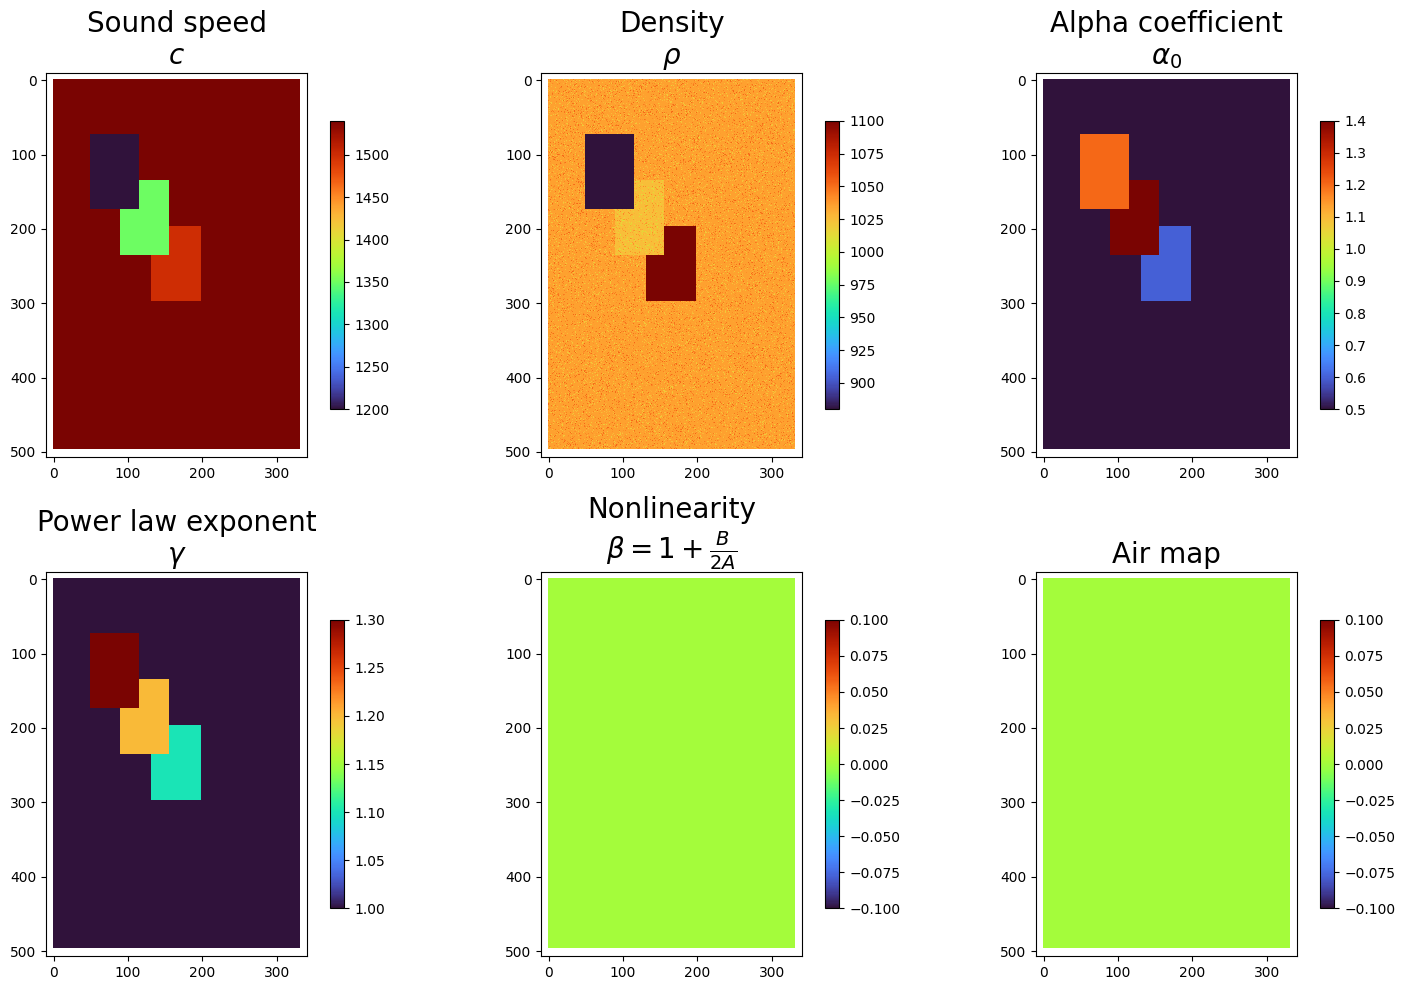

In [11]:
medium.plot(
    show=True,
    export_path=work_dir / "medium.png",
    dpi=50,
)

As you can see, the two objects are embedded in the medium with different acoustic properties.


In [12]:
medium.print_info()

Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.38e-02 m, 4.25e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 8.28e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (497, 331)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4968
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1200.00, max=1540.00
  Density: min=880.00, max=1100.00
  Alpha coeff: min=0.50, max=1.40
  Alpha power: min=1.00, max=1.30
  Beta: min=0.00, max=0.00
  Number of air coords: 0
  Attenuation builder: lookup



### Step 2.3: Define the acoustic source position and the time-varying source signal. (`fullwave.Source`)

In this step, we define the acoustic source position and the time-varying source signal using the `fullwave.Source` class.

We specify the source position as a 2D mask array, where the source location is marked with a value of 1, and all other locations are marked with 0.


In [13]:
# define the pressure source [n_sources, nt]

# initialize the pressure source mask
p_mask = np.zeros((grid.nx, grid.ny), dtype=bool)

# set the source location at the top rows of the grid with specified thickness
element_thickness_px = 3
p_mask[0:element_thickness_px, :] = True

Next, we define the time-varying source signal as a NumPy array. In this example, we use a simple gaussian-modulated sinusoidal pulse as the source signal. center frequency, number of cycles, drop off, and maximum amplitude are specified to generate the source signal.


In [14]:
# define the pressure source [n_sources, nt]d
p0 = np.zeros((p_mask.sum(), grid.nt))  # [n_sources, nt]

# The order of p_coordinates corresponds to the order of sources in p0
p_coordinates = map_to_coords(p_mask)

for i_thickness in range(element_thickness_px):
    # create a gaussian-modulated sinusoidal pulse as the source signal with layer delay
    p0_vec = fullwave.utils.pulse.gaussian_modulated_sinusoidal_signal(
        nt=grid.nt,  # number of time steps
        f0=f0,  # center frequency [Hz]
        duration=duration,  # duration [s]
        ncycles=2,  # number of cycles
        drop_off=2,  # drop off factor
        p0=1e5,  # maximum amplitude [Pa]
        i_layer=i_thickness,
        dt_for_layer_delay=grid.dt,
        cfl_for_layer_delay=grid.cfl,
    )

    # assign the source signal to the corresponding layer
    n_y = p_coordinates.shape[0] // element_thickness_px
    p0[n_y * i_thickness : n_y * (i_thickness + 1), :] = p0_vec.copy()

As a next step, we initialize the `Source` object with the defined source position and source signal.
The `Source` class takes the computational grid (`grid`), source position mask, and source signal as inputs to create a source object that can be used in the wave propagation simulation.


In [15]:
# setup the Source instance
source = fullwave.Source(p0, p_mask)

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [16]:
source.print_info()

Source: 
  Number of sources: 993
  Grid shape: (497, 331)
  Is 3D: False
  p0 shape: (993, 4968)



We can plot the source location with the `source.plot()` method.


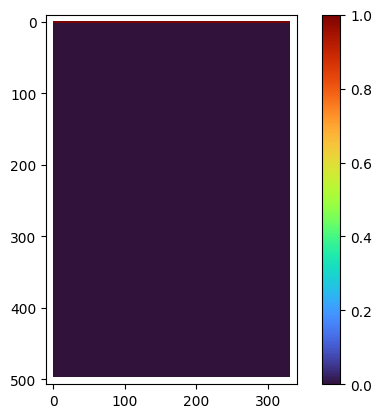

In [17]:
source.plot(
    show=True,
    export_path=work_dir / "source.png",
    dpi=50,
)

Since the source location is at the edge of the domain, it may not be clearly visible in the plot.

The following code zooms in on the source location for better visibility. The first 3 rows are the source location.


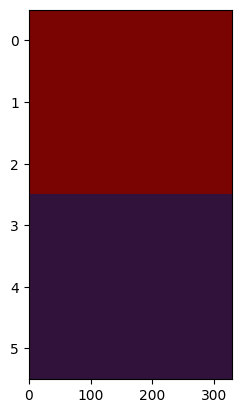

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
plot_utils.plot_array(
    source.mask[:6, :],
    aspect=100,
    show=True,
    export_path=work_dir / "source_zoom.png",
    dpi=10,
)

We can visualize the defined source signal using the `plot_1d_array` function from the `plot_utils` module.


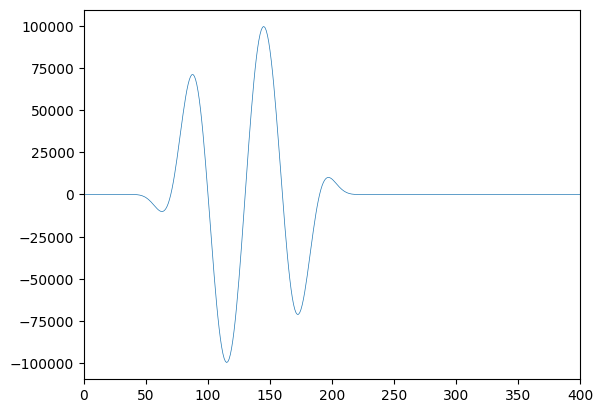

In [19]:
plot_utils.plot_1d_array(
    p0_vec,
    show=True,
    xlim=(0, 400),
    export_path=work_dir / "source_signal.png",
    dpi=30,
)

We can also visualise the source signal matrix using the plot_array function from the plot_utils module.


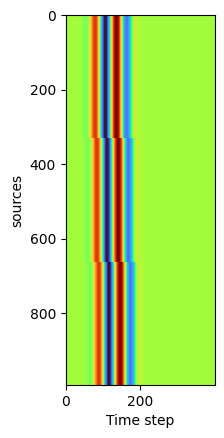

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
plot_utils.plot_array(
    p0[:, :400],
    show=True,
    export_path=work_dir / "source_signal_matrix.png",
    xlabel="Time step",
    ylabel="sources",
    dpi=30,
)

### step2.4: Define the sensor positions to record the wavefield. (`fullwave.Sensor`)

In this step, we define the sensor positions to record the wavefield using the `fullwave.Sensor` class.
We specify the sensor positions as a 2D mask array, where the sensor locations are marked with a value of 1, and all other locations are marked with 0, similar to the source position definition.

Since we want to record the wavefield at all grid points in this example, we set the entire mask to 1.


In [21]:
sensor_mask = np.zeros((grid.nx, grid.ny), dtype=bool)
sensor_mask[:, :] = True

Next, we initialize the `Sensor` object with the defined sensor position mask.
The `Sensor` class takes the sensor position mask as inputs to create a sensor object that can be used in the wave propagation simulation.

We can also define the sampling modulus time for the sensor recordings with `sampling_modulus_time` parameter.
This parameter allows us to control the temporal resolution of the recorded data by specifying how often to record the wavefield during the simulation.
By setting `sampling_modulus_time` to a value greater than 1, we can reduce the size of the output data by recording the wavefield at every nth time step.


In [22]:
sensor = fullwave.Sensor(mask=sensor_mask, sampling_modulus_time=7)

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [23]:
sensor.print_info()

Sensor: 
  Number of sensors: 164507
  Grid shape: (497, 331)
  Is 3D: False



We can plot the sensor location with the `sensor.plot()` method.

The whole domain is covered with sensors in this example, so the plot will show the array filled with ones.


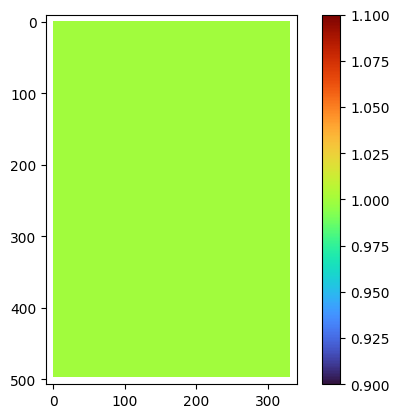

In [24]:
sensor.plot(
    show=True,
    export_path=work_dir / "sensor.png",
    dpi=30,
)

## Step 3. Simulation setup

The simulation configuration is done!
Next, we pass the configured parameters to the Fullwave solver.


### Step 3.1: Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)

The `Solver` class takes the working directory (`work_dir`), computational grid (`grid`), acoustic medium (`medium`), acoustic source (`source`), and sensor (`sensor`) as inputs to create a solver object that can be used to run the wave propagation simulation.

We can specify additional parameters such as `run_on_memory`
`run_on_memory` set to `True` can speed up the simulation significantly, but it requires more RAM. If you have sufficient memory, you can set it to `True` for faster execution. This is especially useful for large-scale simulations where disk I/O can become a bottleneck.
However, The simulation output will be writtein in memory and will not be saved to disk when `run_on_memory` is set to `True`. Make sure to consider this when choosing the setting based on your system's capabilities and simulation requirements.


In [25]:
fw_solver = fullwave.Solver(
    work_dir=work_dir,
    grid=grid,
    medium=medium,
    source=source,
    sensor=sensor,
    run_on_memory=False,
)

We can print the summary of the solver properties using the `print_info` method similar to the `Grid` class.


In [26]:
fw_solver.print_info()


Solver(
  work_dir=outputs/medium_builder

  medium=Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.38e-02 m, 4.25e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 8.28e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (497, 331)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4968
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1200.00, max=1540.00
  Density: min=880.00, max=1100.00
  Alpha coeff: min=0.50, max=1.40
  Alpha power: min=1.00, max=1.30
  Beta: min=0.00, max=0.00
  Number of air coords: 0
  Attenuation builder: lookup

  source=Source: 
  Number of sources: 993
  Grid shape: (497, 331)
  Is 3D: False
  p0 shape: (993, 4968)

  sensor=Senso

### Step 3.2: Execute the simulation.


Now, all of the configurations are set up, and we can run the simulation using the `run` method of the `Solver` class.
The `run` method executes the wave propagation simulation based on the defined grid, medium, source, and sensor configurations.
It performs the necessary computations to simulate the wave propagation and records the wavefield data at the specified sensor locations.


In [27]:
sensor_output = fw_solver.run()

## Step 4. Post-process

The simulation is complete!
Next, we will load and visualize the recorded wavefield data.


### Step 4.1 reshape the recorded wavefield data.

`sensor_output` contains the recorded wavefield data at the sensor locations after the simulation is complete.
But the data is in 1D array format, so we need to reshape it back to the original 2D grid format for further analysis and visualization.

We can use `signal_process.reshape_whole_sensor_to_nt_nx_ny` function from the `fullwave.utils.signal_process` module to reshape the recorded wavefield data.


In [28]:
propagation_map = signal_process.reshape_whole_sensor_to_nt_nx_ny(
    sensor_output,
    grid,
)

### Step 4.2. visualize the results.

We can visualize the wave propagation using the `plot_utils.plot_array` function from the `fullwave.utils.plot_utils` module.


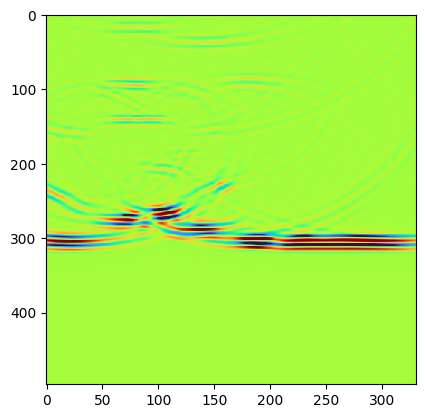

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
p_max_plot = np.abs(propagation_map).max().item() / 2
time_step = propagation_map.shape[0] // 3
plot_utils.plot_array(
    propagation_map[time_step, :, :],
    aspect=propagation_map.shape[2] / propagation_map.shape[1],
    export_path=work_dir / "wave_propagation_snapshot_1.png",
    vmax=p_max_plot,
    vmin=-p_max_plot,
    show=True,
    dpi=80,
)

We can visualize the wave propagation animation using the `plot_utils.plot_wave_propagation_with_map` function from the `fullwave.utils.plot_utils` module as well.


In [30]:
plot_utils.plot_wave_propagation_with_map(
    propagation_map=propagation_map,
    c_map=medium.sound_speed,
    rho_map=medium.density,
    export_name=work_dir / "wave_propagation_animation.gif",
    vmax=p_max_plot,
    vmin=-p_max_plot,
    figsize=(3.5, 4),
    xlabel="Lateral position (mm)",
    ylabel="Axial position (mm)",
    extent=[
        -domain_size[1] / 2 * 1e3,
        domain_size[1] / 2 * 1e3,
        domain_size[0] * 1e3,
        0,
    ],
    dpi=100,
)

plotting animation: 100%|██████████| 51/51 [00:00<00:00, 1545.97it/s]


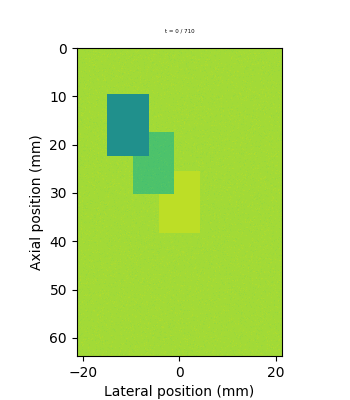

In [31]:
# show work_dir / "wave_propagation_animation.gif"
from IPython.display import Image

Image(filename=work_dir / "wave_propagation_animation.gif")